- First, infill LGM ice using lgm_regrid LGMR notebook
- Then, use ice sheet adjustment LGMR notebook to:
    - make sea ice be 100% where there are ice sheets for LGM and for Late Holocene (Antarctic)
- After that, load LGM sea ice dataset here and infill the sea ice in remaining new ocean area

- this was not quick
- found way to infill and correct problem ice in summer

In [1]:
#!/usr/bin/env python
# coding: utf-8

#########
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
import xesmf as xe
import cartopy.crs as ccrs
import copy
import pandas as pd
import seaborn as sns
import cartopy.feature as cfeature

import warnings
warnings.filterwarnings('ignore')


import metpy
import metpy.calc as mpcalc

In [2]:
## load sea ice data
path = '/home/disk/sipn/vcooper/nobackup/lgm/LGMR/'
holo_ice_adj = xr.open_dataset(path + 'LGMR_SIC_holo_0-4ka_ensmean_ice6g-adj.nc')
lgm_ice_adj = xr.open_dataset(path + 'LGMR_SIC_lgm_19-23ka_ensmean_ice6g-adj.nc')

## load SST data infilled
path = '/home/disk/sipn/vcooper/nobackup/lgm/infilled/'
fname = 'LGMR_holo_SST_monthly_climo_merged.nc'
holo_sst_climo = xr.open_dataset(path + fname)
fname = 'LGMR_lgm_SST_monthly_climo_merged.nc'
lgm_sst_climo = xr.open_dataset(path + fname)

## load ice6g
ice6g = xr.open_dataset('/home/disk/sipn/vcooper/nobackup/lgm/peltier_lgm-mask/' + 'I6_C.VM5a_1deg.21.nc')
ice6g_0 = xr.open_dataset('/home/disk/sipn/vcooper/nobackup/lgm/peltier_lgm-mask/' + 'I6_C.VM5a_1deg.0.nc')

In [3]:
## regrid the holo sst onto the sea ice grid
## this SST will be used to determine the icefrac in "new ocean" areas
newgrid = lgm_ice_adj # desired grid
newgrid['mask'] = xr.where(~np.isnan(newgrid.icefrac[0]),1,0)
data_for_regridding = lgm_sst_climo
data_for_regridding['mask'] = xr.where(~np.isnan(data_for_regridding.sst[0]),1,0)

regridder = xe.Regridder(data_for_regridding, newgrid,
                         method='bilinear',#ignore_degenerate=True,
                         periodic=True,
                         extrap_method = 'inverse_dist',extrap_num_src_pnts=16,
                         filename='bilinear_sst_to_ice_perLGMR.nc',
                         reuse_weights=True)

holo_sst_climo_regrid = regridder(holo_sst_climo)

In [4]:
## regrid ice6g so we can identify what needs infilled

newgrid = lgm_ice_adj.icefrac[0] # desired grid
data_for_regridding = ice6g
data_for_regridding['mask'] = xr.where(~np.isnan(data_for_regridding.sftlf),1,0)

regridder_ice6g = xe.Regridder(data_for_regridding, newgrid,
                         method='bilinear',
                         periodic=True,
#                          extrap_method='inverse_dist',extrap_num_src_pnts=64,
                         filename='bilinear_noextrapc.nc',
                         reuse_weights=True)

ice6g_regrid = regridder_ice6g(data_for_regridding)
ice6g_0_regrid = regridder_ice6g(ice6g_0)


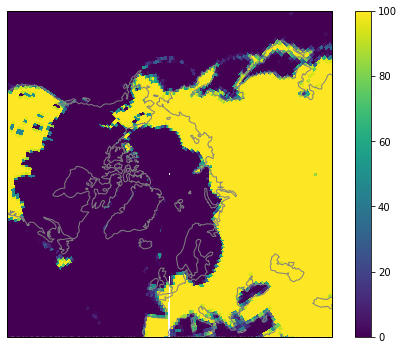

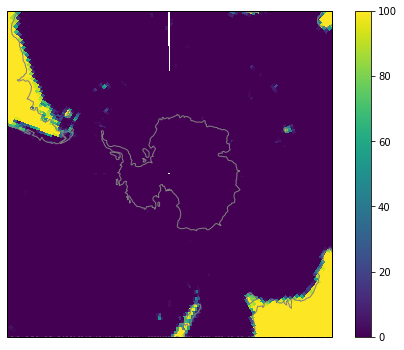

In [5]:
## already used ice_sheet_adjustment ipynb to make sea ice be 100% when ice sheet is present
## now, highlight sea level change areas in arctic that need infilled, i.e.,
## new ocean areas that need to have sea ice

## plot shows land area in LGM that is NOT ice sheet

ds = ice6g.sftlf - ice6g.sftgif.values
cmap_set = 'viridis'

## Arctic
proj = ccrs.NorthPolarStereo()

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.coastlines(color='0.5')
ax.set_extent([-180, 180, 38, 90], ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,ds,
               transform=ccrs.PlateCarree(),vmin=0,
               cmap=cmap_set,alpha=1)
plt.colorbar()
plt.show()

## Antarctic
proj = ccrs.SouthPolarStereo()

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.coastlines(color='0.5')
ax.set_extent([-180, 180, -38, -90], ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,ds,
               transform=ccrs.PlateCarree(),vmin=0,
               cmap=cmap_set,alpha=1)
plt.colorbar()
plt.show()

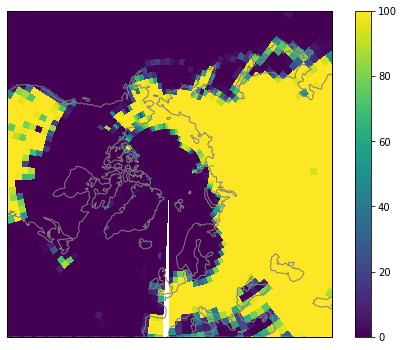

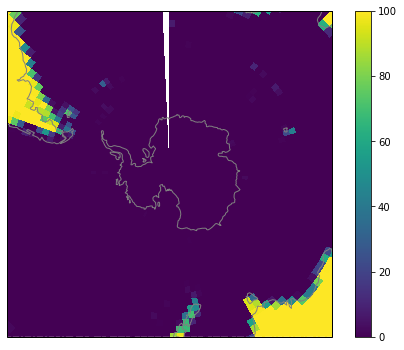

In [6]:
## regridded version

ds = ice6g_regrid.sftlf - ice6g_regrid.sftgif.values
cmap_set = 'viridis'

## Arctic
proj = ccrs.NorthPolarStereo()

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.coastlines(color='0.5')
ax.set_extent([-180, 180, 38, 90], ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,ds,
               transform=ccrs.PlateCarree(),vmin=0,
               cmap=cmap_set,alpha=1)
plt.colorbar()
plt.show()

## Antarctic
proj = ccrs.SouthPolarStereo()

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.coastlines(color='0.5')
ax.set_extent([-180, 180, -38, -90], ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,ds,
               transform=ccrs.PlateCarree(),vmin=0,
               cmap=cmap_set,alpha=1)
plt.colorbar()
plt.show()

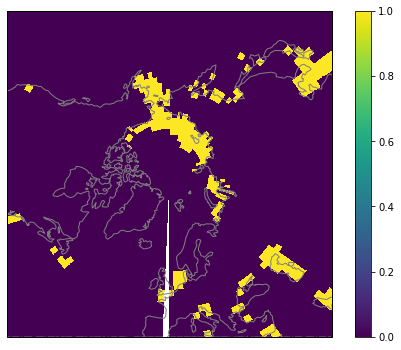

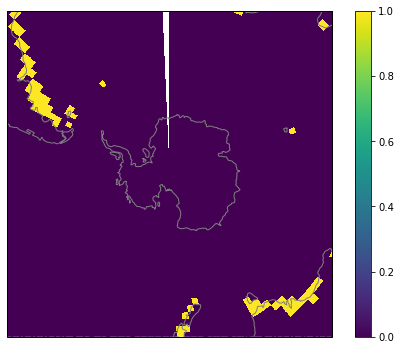

In [7]:
## regridded version

ds = ice6g_regrid.sftlf - ice6g_regrid.sftgif.values - ice6g_0_regrid.sftlf.values
ds = xr.where(ds > 20, 1,0)
cmap_set = 'viridis'

## Arctic
proj = ccrs.NorthPolarStereo()

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.coastlines(color='0.5')
ax.set_extent([-180, 180, 38, 90], ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,ds,
               transform=ccrs.PlateCarree(),vmin=0,
               cmap=cmap_set,alpha=1)
plt.colorbar()
plt.show()

## Antarctic
proj = ccrs.SouthPolarStereo()

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.coastlines(color='0.5')
ax.set_extent([-180, 180, -38, -90], ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,ds,
               transform=ccrs.PlateCarree(),vmin=0,
               cmap=cmap_set,alpha=1)
plt.colorbar()
plt.show()

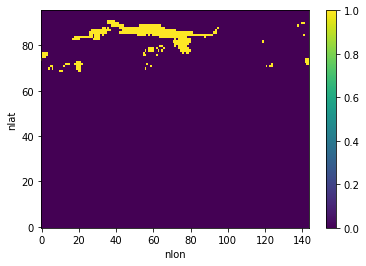

In [8]:
## only target northern hemisphere spots
## -- where landfrac change at least 20% at lats > 40
## -- but expand to where landfrac > 0 at lats > 65 because
## -- of some tricky spots particular in [barents/kara] sea (LGM only)

infillzone = ice6g_regrid.sftlf - ice6g_regrid.sftgif.values - ice6g_0_regrid.sftlf.values
infillzone = infillzone/100. ## convert to fraction
infillmask_all = xr.where((infillzone > 0.2) & (infillzone.lat > 40), 1, 0)
infillmask_highlat = xr.where((infillzone > 0) & (infillzone.lat > 65), 1, 0)
infillmask = xr.where(infillmask_highlat > infillmask_all, infillmask_highlat, infillmask_all)

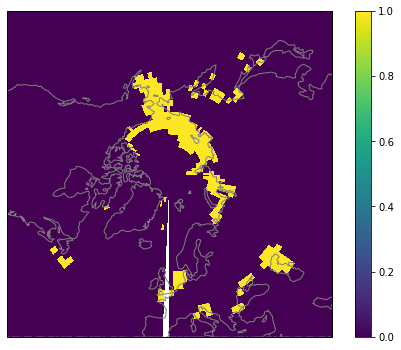

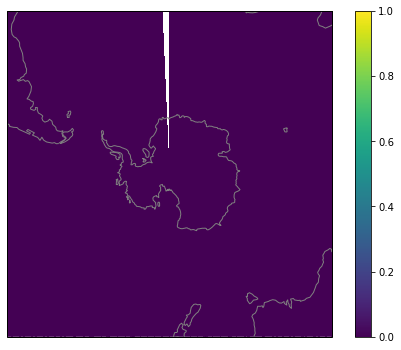

In [22]:
## final infill mask

ds = infillmask
cmap_set = 'viridis'

## Arctic
proj = ccrs.NorthPolarStereo()

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.coastlines(color='0.5')
ax.set_extent([-180, 180, 38, 90], ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,ds,
               transform=ccrs.PlateCarree(),vmin=0,
               cmap=cmap_set,alpha=1)
plt.colorbar()
plt.show()

## Antarctic
proj = ccrs.SouthPolarStereo()

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.coastlines(color='0.5')
ax.set_extent([-180, 180, -38, -90], ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,ds,
               transform=ccrs.PlateCarree(),vmin=0,
               cmap=cmap_set,alpha=1)
plt.colorbar()
plt.show()

In [76]:
%%time
## apply modified Hurrell correction to icefrac based on SST
## and 

## store new data in this dataset
icecombo_all = holo_ice_adj.icefrac.to_dataset().copy(
    data={'icefrac':np.zeros_like(holo_ice_adj.icefrac.values)})

for msel in range(12):
    ## these "prediddle"names are lazy coding, copied from other place. names meaningless here.
    sst_prediddle_adj = holo_sst_climo_regrid.sst[msel]
    sic_prediddle_adj = holo_ice_adj.icefrac[msel]
    
    ## extra holocene adjustment to keep sea ice if already there
    ## CURRENT: replace sea ice everywhere according to Hurrell ice max...
    latmin1=67
    infillmask_holo = xr.where((infillmask>-100) & (holo_ice_adj.icefrac[msel] < 100), 1,0)
    infillmask_holo = xr.where(infillmask_holo & (infillmask_holo.lat > latmin1),1,0) # only NH

    ## ADJUSTED HURRELL CORRECTION: this brings icefrac UP to the icemax, instead of capping at icemax
    ## but is only applied to the infill areas.
    ## the capping will happen later everywhere during the prep-cam-bc step
    
    # ; 5) Hurrell et al correction to ice frac (if -1.8 < SST < 4.97)
    # ice_max = 100.*(0.729-(SST+1.8)/9.328)^(1./3.)
    # SEAICE = where((SST.gt.-1.8).and.(SST.lt.4.97).and.(SEAICE.gt.ice_max), ice_max, SEAICE)
    ice_max = (0.729-(sst_prediddle_adj+1.8)/9.328)**(1./3.)
    sic_prediddle_adj = xr.where((sst_prediddle_adj > -1.8) &  ##
                                 (sst_prediddle_adj < 4.97) & 
                                 (infillmask_holo),# & 
    #                                     (sic_prediddle_adj > ice_max), ## this is the change
                                         ice_max, sic_prediddle_adj)

    ## Extra correction to make everything colder SST than -1.8 be 100% sea ice
#     sic_prediddle_adj = xr.where((sst_prediddle_adj < -1.8) & (infillmask_holo), 1., sic_prediddle_adj)
    
    ## holocene edit to NOT reduce original sea ice
    sic_prediddle_adj = xr.where((sst_prediddle_adj < -1.8) & (infillmask_holo), 1., 
                                 np.max([sic_prediddle_adj, holo_ice_adj.icefrac[msel]],axis=0))
#     sic_prediddle_adj = np.max([sic_prediddle_adj, holo_ice_adj.icefrac[msel]],axis=0)
    
    # HOLOCENE dont need meridian adjustment
#     latmin=68
#     for imer,val in enumerate(sic_prediddle_adj.transpose('nlon',...)):
#         valnh = val.where(val.lat > latmin)

#         ## check maximum ice poleward and equatorward, along meridian
#         max_ice_poleward = np.array([valnh[j:].max() for j in range(len(valnh))])
#         max_ice_equatorward = np.array([valnh[0:j+1].max() for j in range(len(valnh))])

#         ## ice ceiling is maximum value ice will increase to. don't go below the original
#         ## ice value, and don't go above the maximum SIC poleward of position
#         ice_ceiling = np.array([np.max([p,v]) for p,v in zip(max_ice_poleward,valnh)])
#         max_ice_equatorward = np.where((max_ice_equatorward > valnh) & (max_ice_equatorward > ice_ceiling), 
#                                    ice_ceiling, max_ice_equatorward)

#         val = xr.where(val.lat > latmin, max_ice_equatorward, val)
#         sic_prediddle_adj[:,imer] = val
        
    ## smoothing the infill; treat land as ice for smoothing, otherwise always reduces at coast
#     forsmoothing = np.max([sic_prediddle_adj,ice6g_regrid.sftlf/100],axis=0,keepdims=1).squeeze()
#     op = plt.imshow(mpcalc.smooth_gaussian(forsmoothing,5))
#     smoothed = op.get_array().data
#     plt.close()

    ## set mask for where to apply the smoothed data
#     infillmask_smoothing = xr.where((infillzone > 0.001) & (infillzone.lat > 60), 1, 0)

#     sic_prediddle_adj2 = xr.where((infillmask_smoothing),
#                          smoothed, sic_prediddle_adj)
    #     icecombo_all.icefrac[msel] = sic_prediddle_adj2.values

    ## 3 version of infill areas: mean of smoothed and unsmoothed (avoids sharp edges
    ## that otherwise arise at boundary of where smoothing is not applied bc no infilling
    ## required there)
#     sic_prediddle_adj3 = xr.where((infillmask_smoothing),
#                           np.mean([smoothed,sic_prediddle_adj],axis=0), sic_prediddle_adj)
    
#     icecombo_all.icefrac[msel] = sic_prediddle_adj3.values
    
    ## VERSION 4 of ice smoothing
    ## solution to smoothing masked data:
    ## https://stackoverflow.com/questions/50009141/smoothing-without-filling-missing-values-with-zeros
    ## only use ocean for smoothing, nan the land
    holocean = xr.where(ice6g_0_regrid.sftlf < 75,1,0)
    U = sic_prediddle_adj.where(holocean).values
    V = U.copy()
    V[U!=U]=0
    op = plt.imshow(mpcalc.smooth_gaussian(V,4))
    VV = op.get_array().data
    plt.close()

    W = 0*U.copy()+1
    W[U!=U]=0
    op2 = plt.imshow(mpcalc.smooth_gaussian(W,4))
    WW = op2.get_array().data
    plt.close()

    smoothed = VV/WW

    ## smooth all NH ice, and only SH ice near AA continent
    infillmask_smoothing4 = xr.where((holocean) & 
                                     ((infillzone.lat > 40) | (infillzone.lat < -56)), 1, 0)
    

    sic_prediddle_adj4 = xr.where(infillmask_smoothing4,smoothed, sic_prediddle_adj)

    ## holocene edit to NOT reduce from original sea ice
    sic_prediddle_adj4 = np.max([sic_prediddle_adj4, holo_ice_adj.icefrac[msel]],axis=0)
    
    icecombo_all.icefrac[msel] = sic_prediddle_adj4
    
    print(msel, ' done')

0  done
1  done
2  done
3  done
4  done
5  done
6  done
7  done
8  done
9  done
10  done
11  done
CPU times: user 718 ms, sys: 4.23 ms, total: 722 ms
Wall time: 714 ms


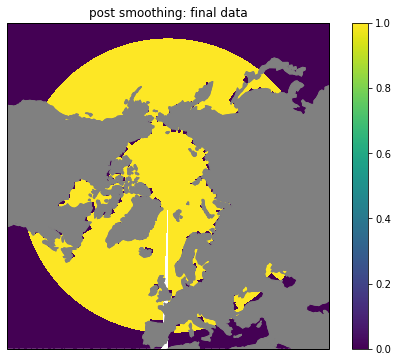

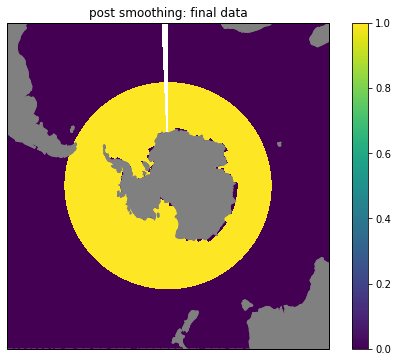

In [75]:
## where the smoothing will be accepted
proj = ccrs.NorthPolarStereo()

ds = infillmask_smoothing4

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.coastlines(color='0.5')
ax.set_extent([-180, 180, 36, 90], ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,
               ds,
               transform=ccrs.PlateCarree(),
               cmap='viridis')
ax.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
plt.colorbar()
plt.show()

proj = ccrs.SouthPolarStereo()

ds = infillmask_smoothing4

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.coastlines(color='0.5')
ax.set_extent([-180, 180, -36, -90], ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,
               ds,
               transform=ccrs.PlateCarree(),
               cmap='viridis')
ax.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
plt.colorbar()
plt.show()

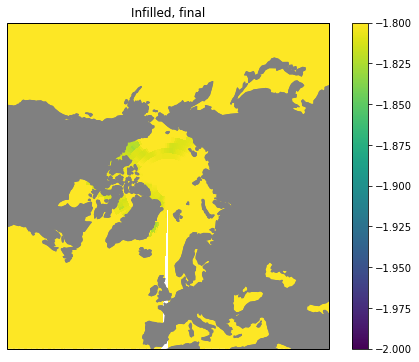

In [65]:
proj = ccrs.NorthPolarStereo()

# ds = icecombo_all.icefrac[msel]
ds = sst_prediddle_adj

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.coastlines(color='0.5')
ax.set_extent([-180, 180, 36, 90], ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,
               ds,
               transform=ccrs.PlateCarree(),
               cmap='viridis',vmin=-2,vmax=-1.8)
plt.title('Infilled, final')
ax.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
plt.colorbar()
plt.show()

## Check results: single month

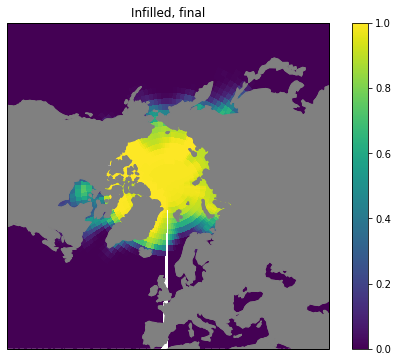

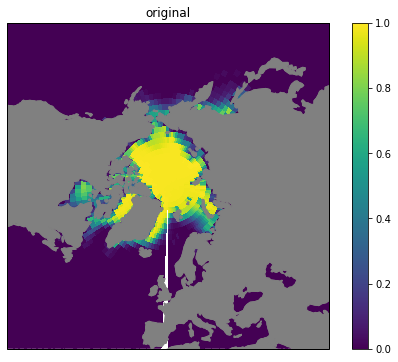

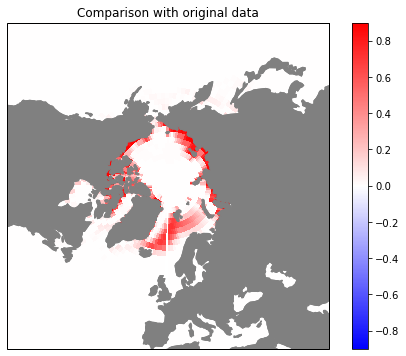

In [74]:
# PLOTTING TO CHECK RESULTS
proj = ccrs.NorthPolarStereo()

# ds = icecombo_all.icefrac[msel]
ds = sic_prediddle_adj
# ds = smoothed

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.coastlines(color='0.5')
ax.set_extent([-180, 180, 36, 90], ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,
               smoothed,
               transform=ccrs.PlateCarree(),
               cmap='viridis')
plt.title('Infilled, final')
ax.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
plt.colorbar()
plt.show()

ds = holo_ice_adj.icefrac[msel]

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.coastlines(color='0.5')
ax.set_extent([-180, 180, 36, 90], ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,
               ds,
               transform=ccrs.PlateCarree(),
               cmap='viridis')
plt.title('original')
ax.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
plt.colorbar()
plt.show()

# PLOTTING TO CHECK RESULTS
proj = ccrs.NorthPolarStereo()

ds = sic_prediddle_adj4 - holo_ice_adj.icefrac[msel]

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.coastlines(color='0.5')
ax.set_extent([-180, 180, 36, 90], ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,
               ds,
               transform=ccrs.PlateCarree(),vmin=-0.9,vmax=0.9,
               cmap='bwr')
plt.title('Comparison with original data')
ax.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
plt.colorbar()
plt.show()

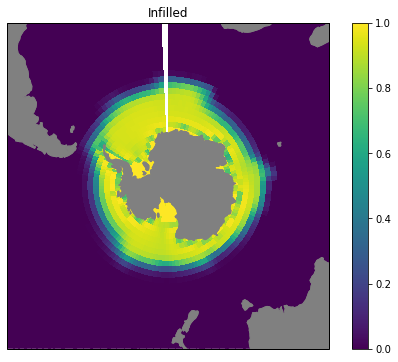

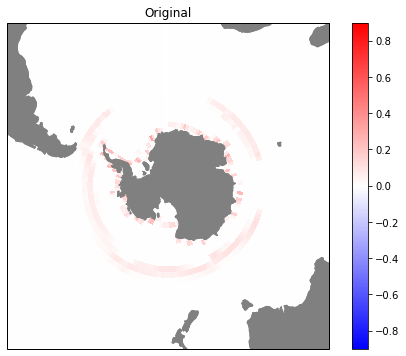

In [51]:
# PLOTTING TO CHECK RESULTS
proj = ccrs.SouthPolarStereo()

ds = icecombo_all.icefrac[msel]

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.coastlines(color='0.5')
ax.set_extent([-180, 180, -36, -90], ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,
               ds,
               transform=ccrs.PlateCarree(),
               cmap='viridis')
plt.title('Infilled')
ax.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
plt.colorbar()
plt.show()

# PLOTTING TO CHECK RESULTS
# proj = ccrs.NorthPolarStereo()

ds = icecombo_all.icefrac[msel] - holo_ice_adj.icefrac[msel].values

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.coastlines(color='0.5')
ax.set_extent([-180, 180, -36, -90], ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,
               ds,
               transform=ccrs.PlateCarree(),vmin=-0.9,vmax=0.9,
               cmap='bwr')
plt.title('Original')
ax.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
plt.colorbar()
plt.show()

# Check all months

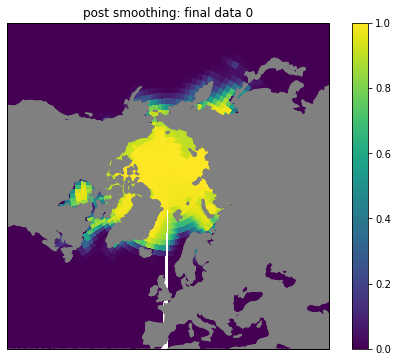

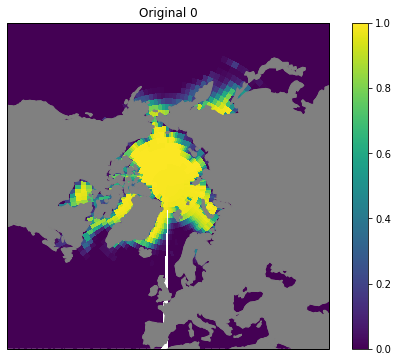

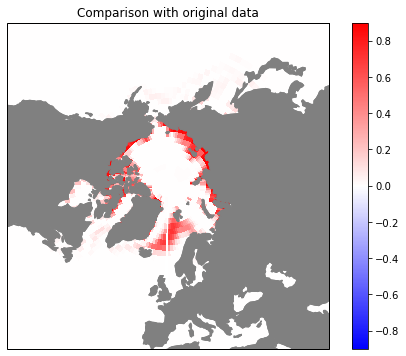

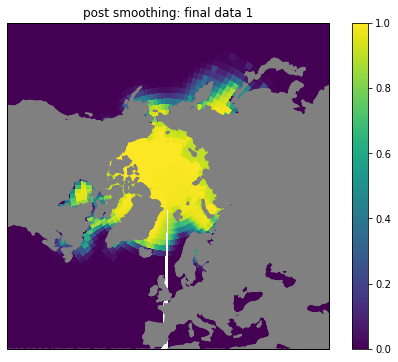

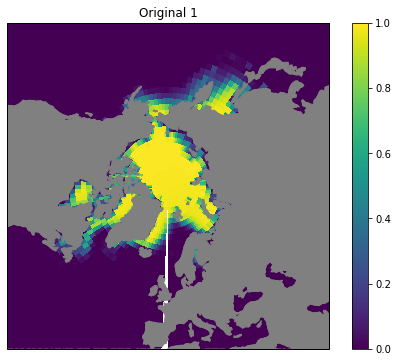

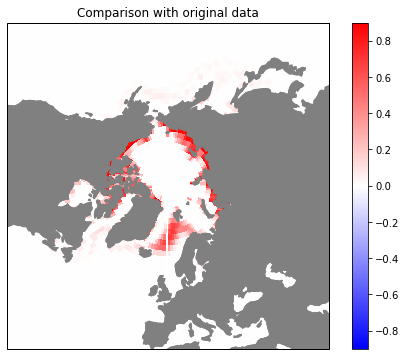

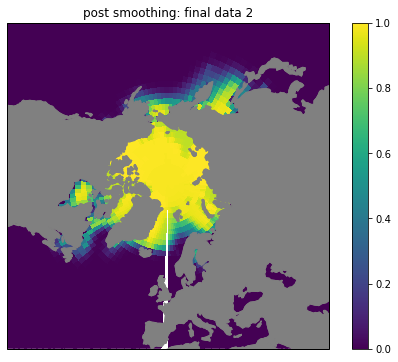

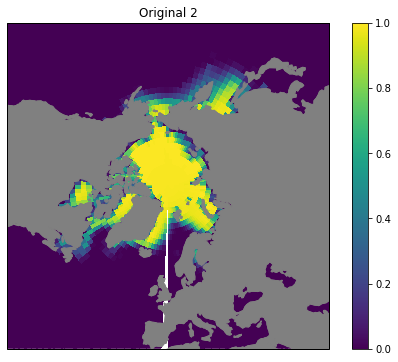

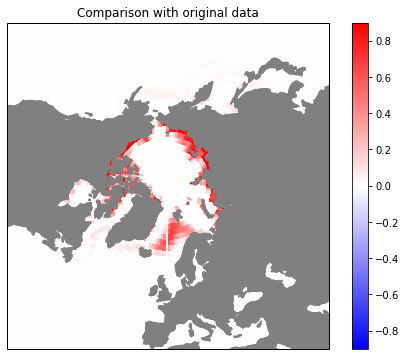

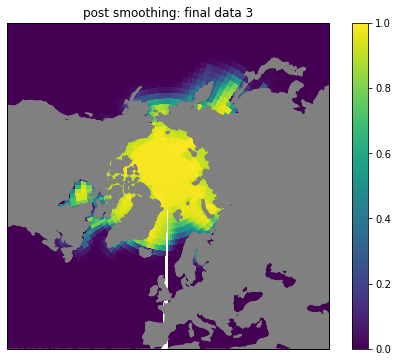

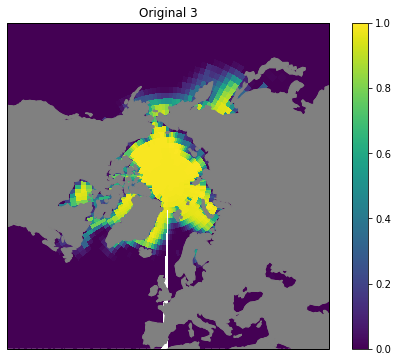

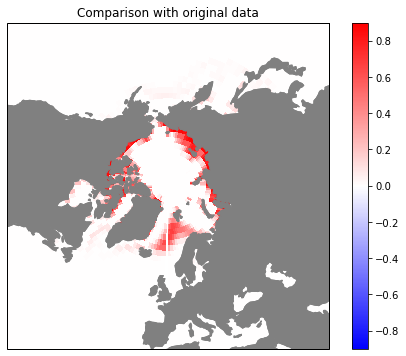

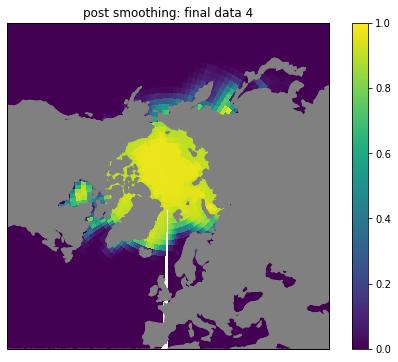

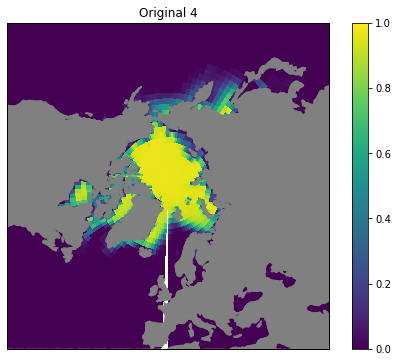

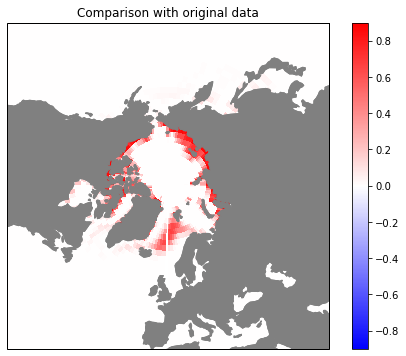

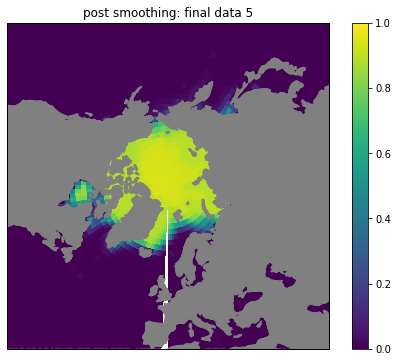

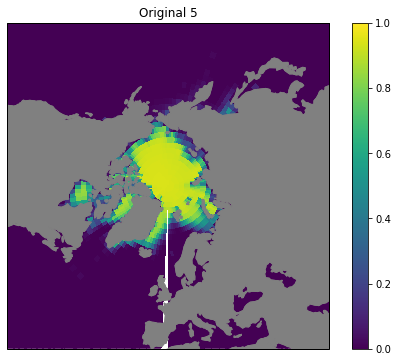

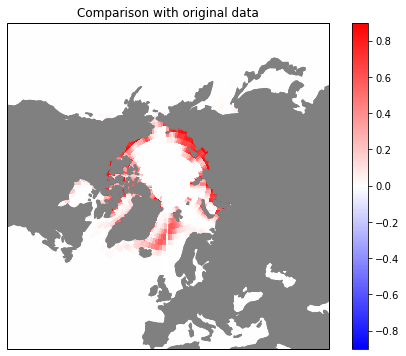

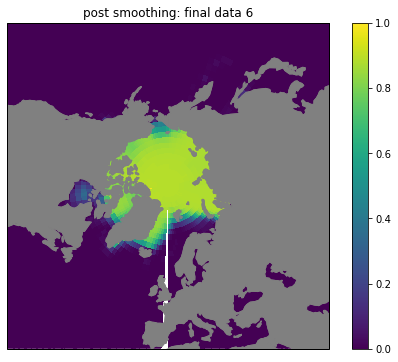

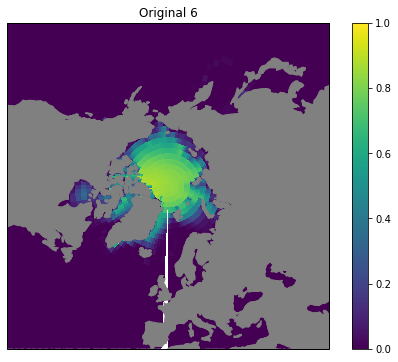

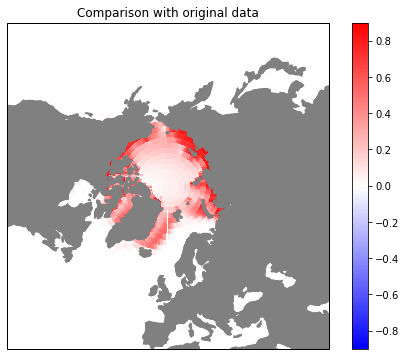

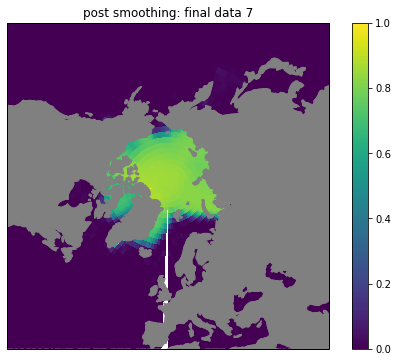

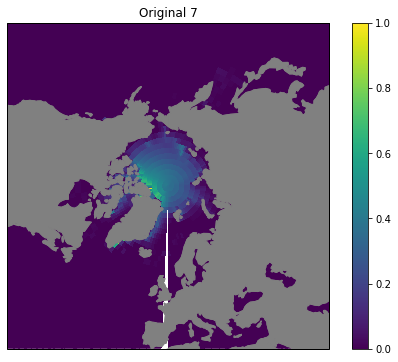

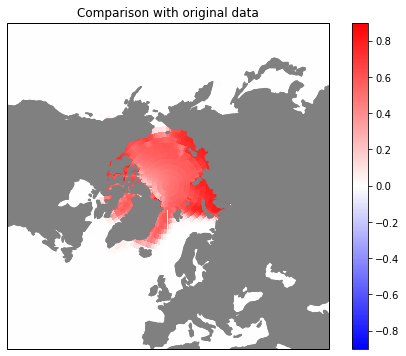

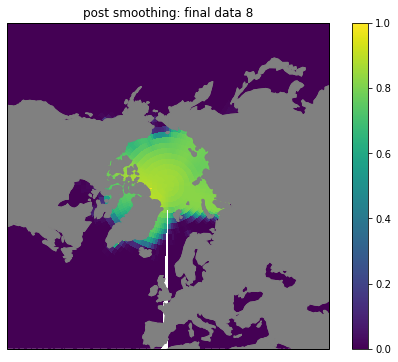

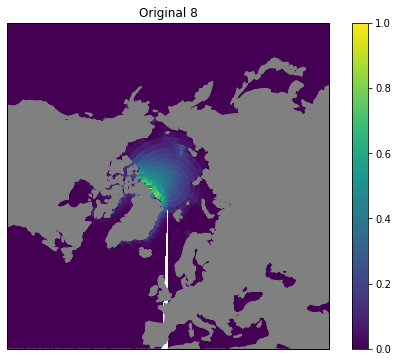

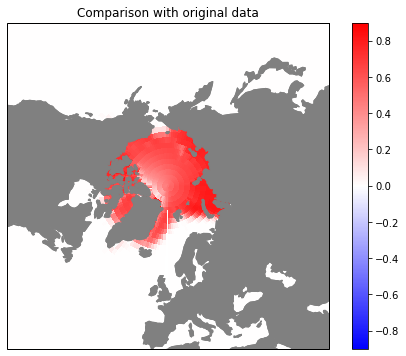

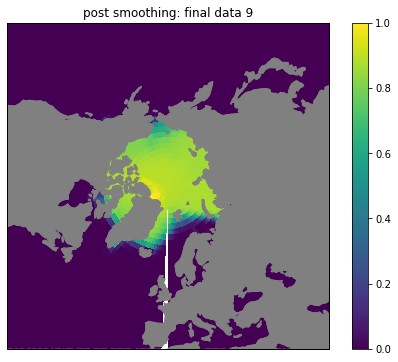

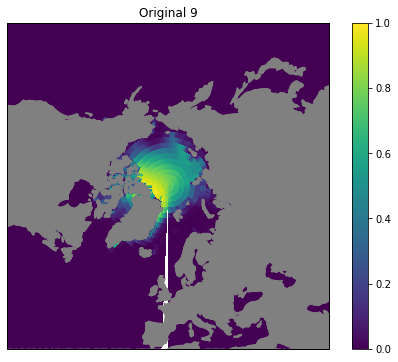

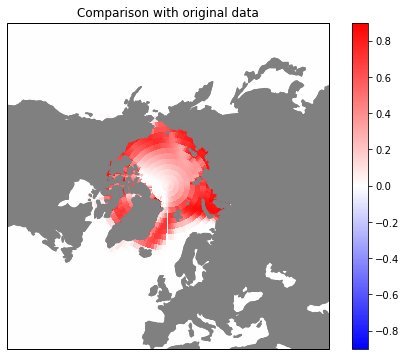

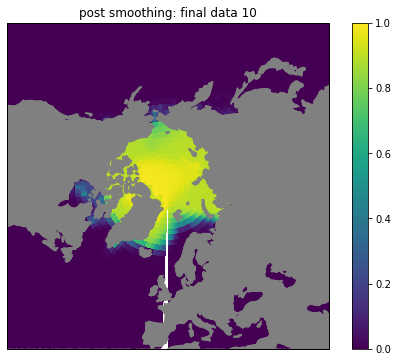

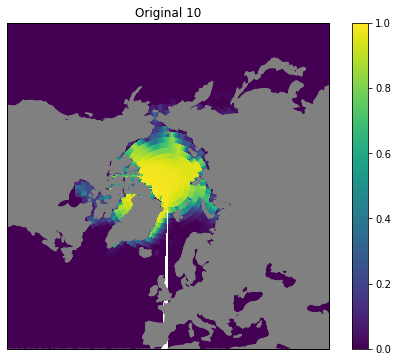

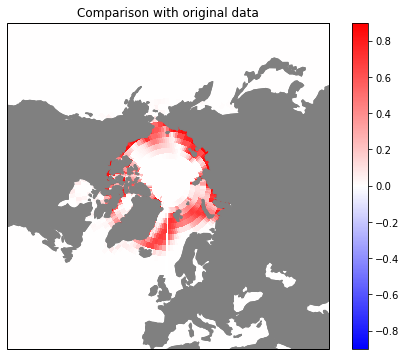

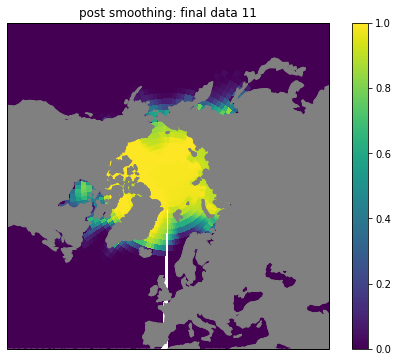

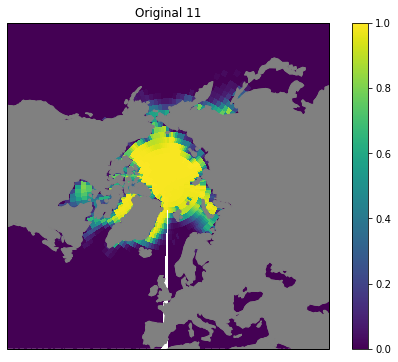

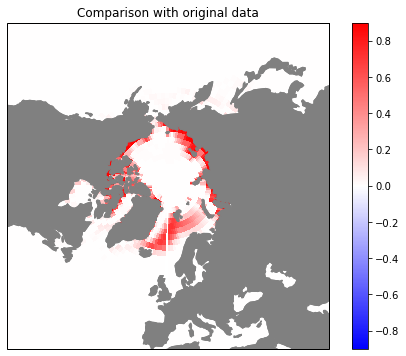

In [78]:
for msel in range(12):
    # PLOTTING TO CHECK RESULTS
    proj = ccrs.NorthPolarStereo()

    ds = icecombo_all.icefrac[msel]

    fig = plt.subplots(figsize=(8,6))
    ax = plt.subplot(projection=proj)
    ax.coastlines(color='0.5')
    ax.set_extent([-180, 180, 36, 90], ccrs.PlateCarree())
    plt.pcolormesh(ds.lon,ds.lat,
                   ds,
                   transform=ccrs.PlateCarree(),
                   cmap='viridis')
    plt.title('post smoothing: final data ' + str(msel))
    ax.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
    plt.colorbar()
    plt.show()
    
    ds = holo_ice_adj.icefrac[msel]

    fig = plt.subplots(figsize=(8,6))
    ax = plt.subplot(projection=proj)
    ax.coastlines(color='0.5')
    ax.set_extent([-180, 180, 36, 90], ccrs.PlateCarree())
    plt.pcolormesh(ds.lon,ds.lat,
                   ds,
                   transform=ccrs.PlateCarree(),
                   cmap='viridis')
    plt.title('Original ' + str(msel))
    ax.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
    plt.colorbar()
    plt.show()

    # PLOTTING TO CHECK RESULTS
    proj = ccrs.NorthPolarStereo()

    ds = icecombo_all.icefrac[msel] - holo_ice_adj.icefrac[msel].values

    fig = plt.subplots(figsize=(8,6))
    ax = plt.subplot(projection=proj)
    ax.coastlines(color='0.5')
    ax.set_extent([-180, 180, 36, 90], ccrs.PlateCarree())
    plt.pcolormesh(ds.lon,ds.lat,
                   ds,
                   transform=ccrs.PlateCarree(),vmin=-0.9,vmax=0.9,
                   cmap='bwr')
    plt.title('Comparison with original data')
    ax.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
    plt.colorbar()
    plt.show()

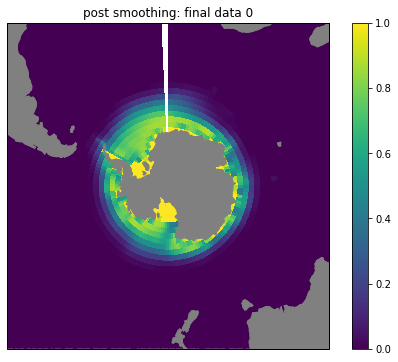

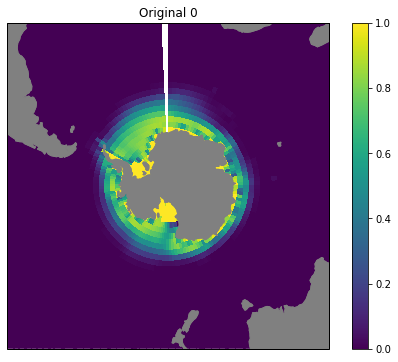

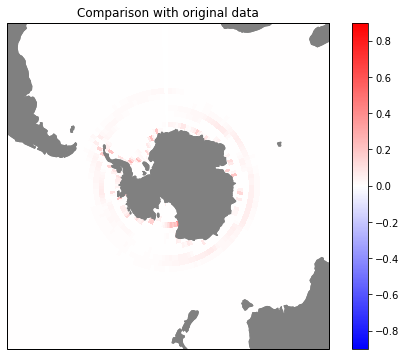

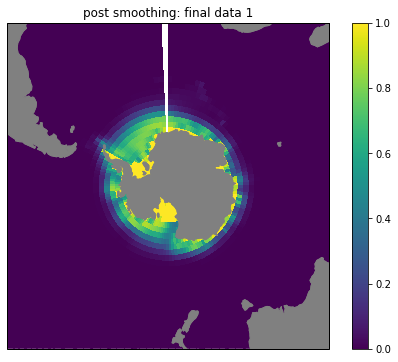

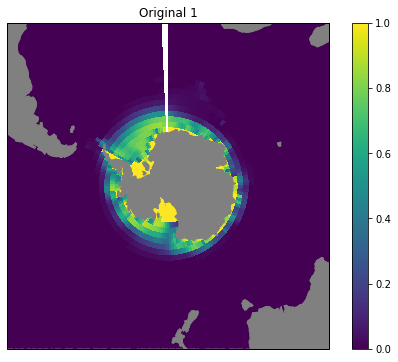

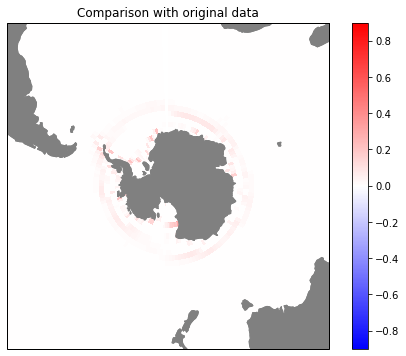

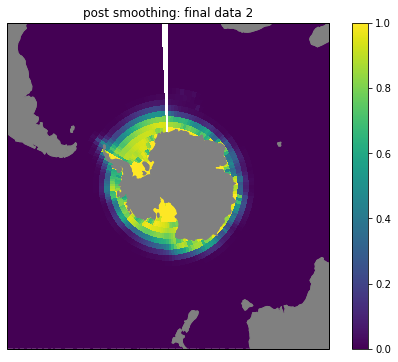

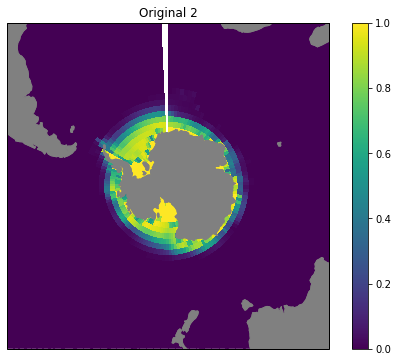

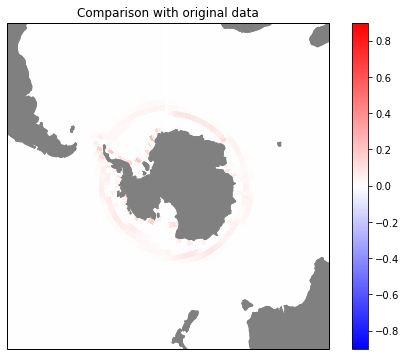

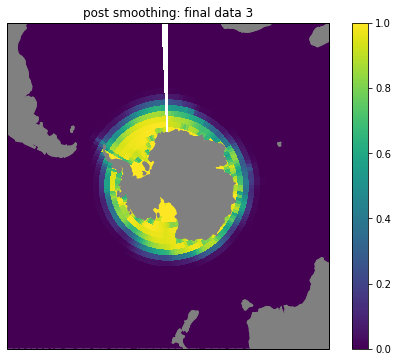

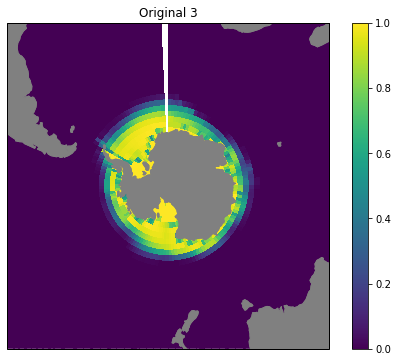

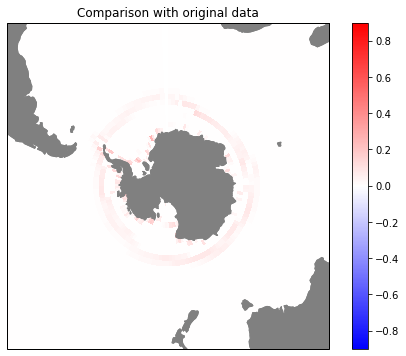

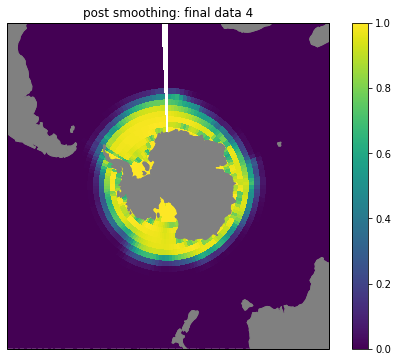

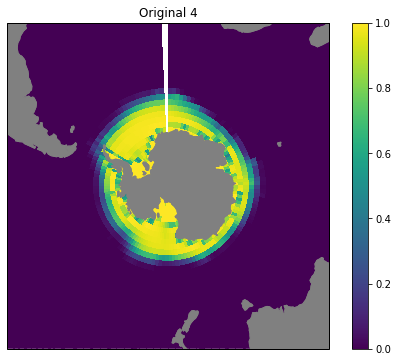

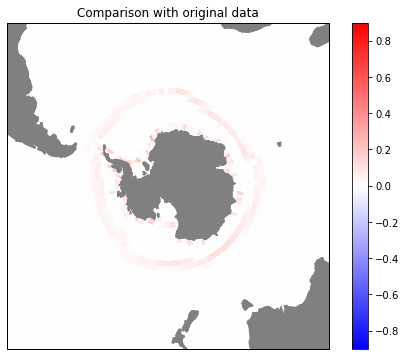

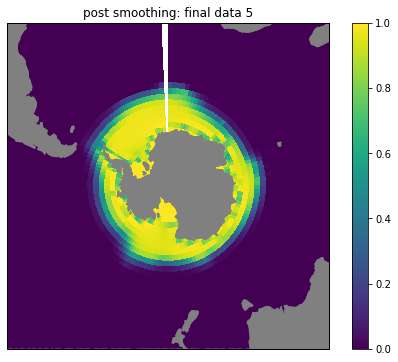

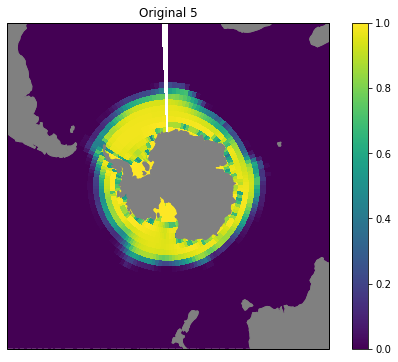

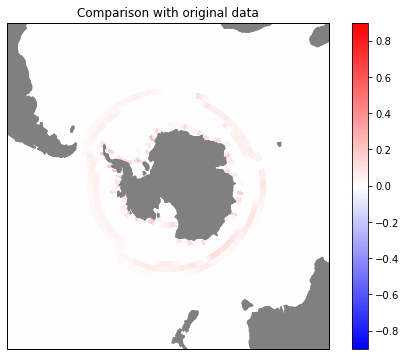

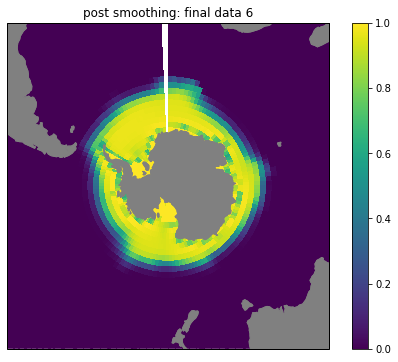

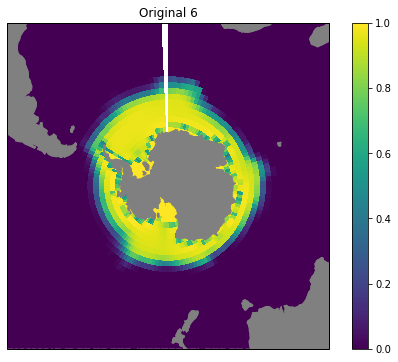

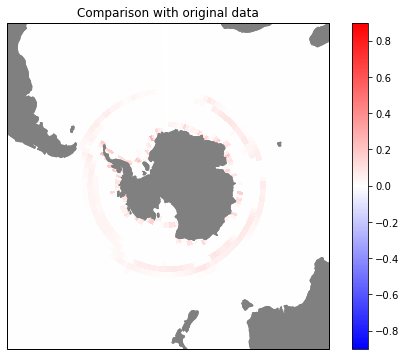

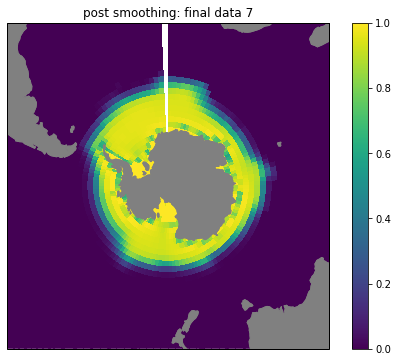

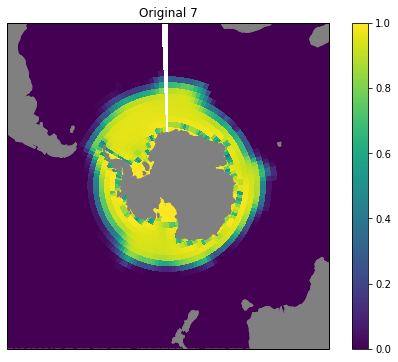

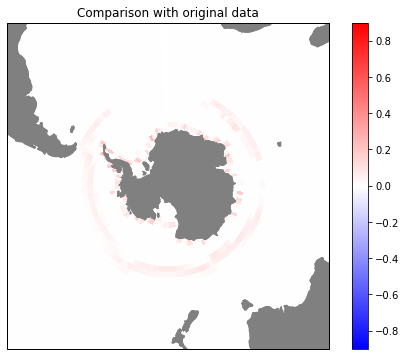

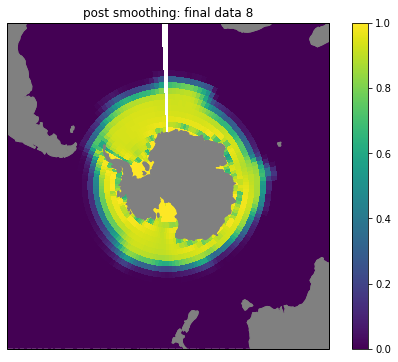

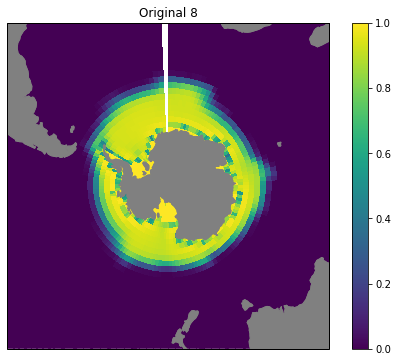

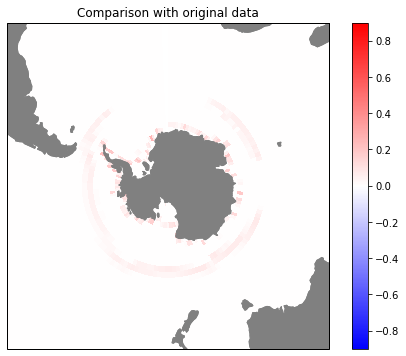

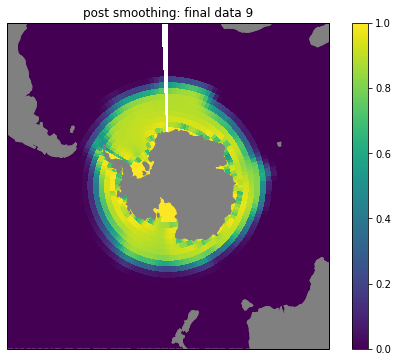

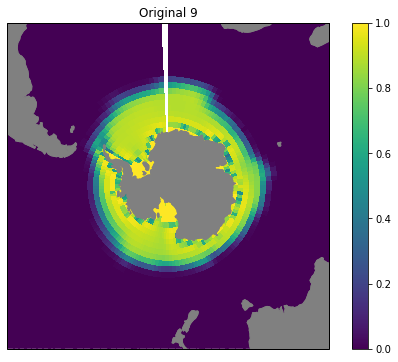

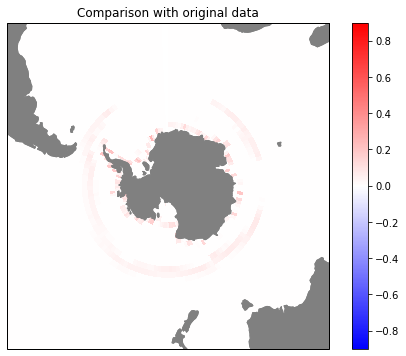

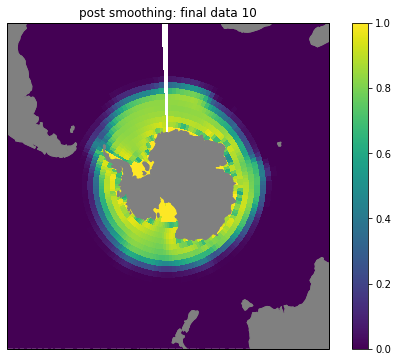

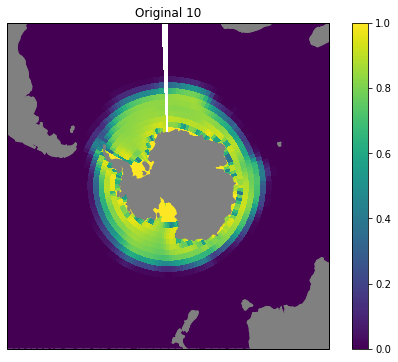

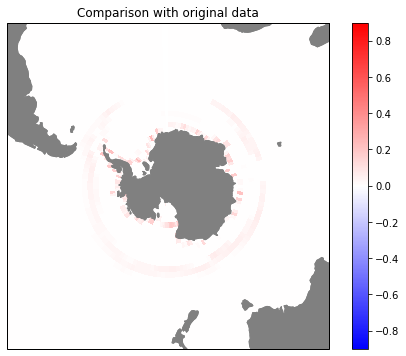

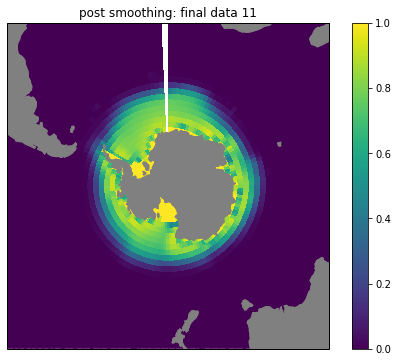

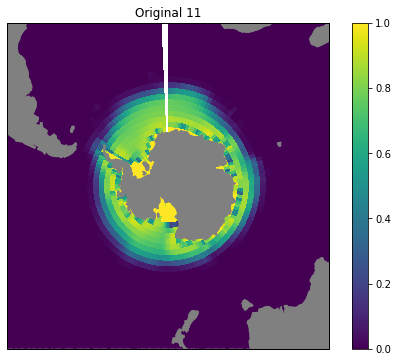

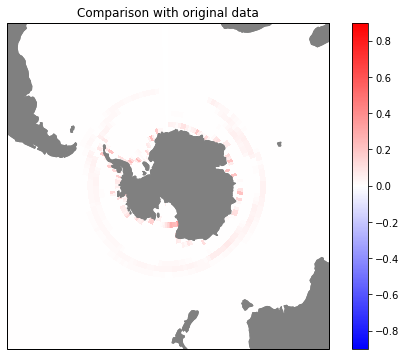

In [80]:
for msel in range(12):
    # PLOTTING TO CHECK RESULTS
    proj = ccrs.SouthPolarStereo()

    ds = icecombo_all.icefrac[msel]

    fig = plt.subplots(figsize=(8,6))
    ax = plt.subplot(projection=proj)
    ax.coastlines(color='0.5')
    ax.set_extent([-180, 180, -36, -90], ccrs.PlateCarree())
    plt.pcolormesh(ds.lon,ds.lat,
                   ds,
                   transform=ccrs.PlateCarree(),
                   cmap='viridis')
    plt.title('post smoothing: final data ' + str(msel))
    ax.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
    plt.colorbar()
    plt.show()
    
    ds = holo_ice_adj.icefrac[msel]

    fig = plt.subplots(figsize=(8,6))
    ax = plt.subplot(projection=proj)
    ax.coastlines(color='0.5')
    ax.set_extent([-180, 180, -36, -90], ccrs.PlateCarree())
    plt.pcolormesh(ds.lon,ds.lat,
                   ds,
                   transform=ccrs.PlateCarree(),
                   cmap='viridis')
    plt.title('Original ' + str(msel))
    ax.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
    plt.colorbar()
    plt.show()

    # PLOTTING TO CHECK RESULTS
#     proj = ccrs.NorthPolarStereo()

    ds = icecombo_all.icefrac[msel] - holo_ice_adj.icefrac[msel].values

    fig = plt.subplots(figsize=(8,6))
    ax = plt.subplot(projection=proj)
    ax.coastlines(color='0.5')
    ax.set_extent([-180, 180, -36, -90], ccrs.PlateCarree())
    plt.pcolormesh(ds.lon,ds.lat,
                   ds,
                   transform=ccrs.PlateCarree(),vmin=-0.9,vmax=0.9,
                   cmap='bwr')
    plt.title('Comparison with original data')
    ax.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
    plt.colorbar()
    plt.show()

In [85]:
!ls -ltr /home/disk/sipn/vcooper/nobackup/lgm/infilled/

total 427504
-rw-r--r-- 1 vcooper atgstaff  2957320 Aug  7  2021 lgmDA_lgm_SST_monthly_climo_krigged_01.nc
-rw-r--r-- 1 vcooper atgstaff  3942883 Aug  7  2021 lgmDA_lgm_SST_monthly_climo_merged_01.nc
-rw-r--r-- 1 vcooper atgstaff  2957320 Aug  7  2021 lgmDA_lgm_SST_monthly_climo_krigged_02.nc
-rw-r--r-- 1 vcooper atgstaff  3942883 Aug  7  2021 lgmDA_lgm_SST_monthly_climo_merged_02.nc
-rw-r--r-- 1 vcooper atgstaff  2957320 Aug  7  2021 lgmDA_lgm_SST_monthly_climo_krigged_03.nc
-rw-r--r-- 1 vcooper atgstaff  3942883 Aug  7  2021 lgmDA_lgm_SST_monthly_climo_merged_03.nc
-rw-r--r-- 1 vcooper atgstaff  2957320 Aug  7  2021 lgmDA_lgm_SST_monthly_climo_krigged_04.nc
-rw-r--r-- 1 vcooper atgstaff  3942883 Aug  7  2021 lgmDA_lgm_SST_monthly_climo_merged_04.nc
-rw-r--r-- 1 vcooper atgstaff  2957320 Aug  7  2021 lgmDA_lgm_SST_monthly_climo_krigged_05.nc
-rw-r--r-- 1 vcooper atgstaff  3942883 Aug  7  2021 lgmDA_lgm_SST_monthly_climo_merged_05.nc
-rw-r--r-- 1 vcooper atgstaff  2957320 Aug  7  2021 

## CHeck seasonality

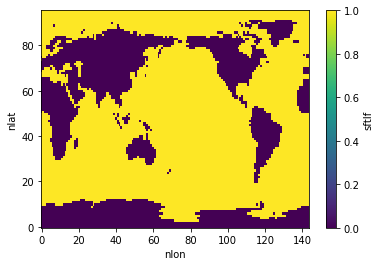

In [88]:
holocean.plot()

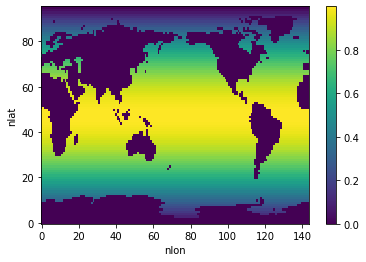

In [90]:
coswts = xr.where(holocean, np.cos(np.deg2rad(holocean.lat)),0)
coswts.plot()

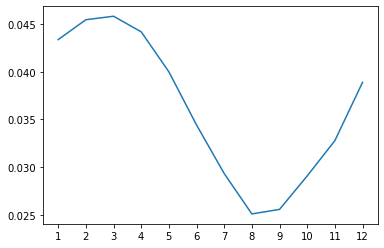

In [100]:
plt.plot(np.arange(12)+1,
         (icecombo_all.where(icecombo_all.lat > 0) * coswts/coswts.sum()).sum(dim=['nlat','nlon']).icefrac)
plt.xticks(np.arange(12)+1)
plt.show()

In [101]:
## save files
savepath = '/home/disk/sipn/vcooper/nobackup/lgm/infilled/'
# fname = 'LGMR_lgm_SIC_monthly_climo_merged.nc'
fname = 'LGMR_holo_SIC_monthly_climo_merged.nc'

icecombo_all.to_netcdf(savepath + fname)
print('finished saving')

finished saving


### Next step: prep_cam_bc